In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
#import tensorflow as tf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
from simulator2 import Simulator2, div2
from renderer import Renderer

GPUs found : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
def force2(m,n,p,w):
    f = np.zeros((m,n,p,3))
    f[17:22,:,17:22,1] = 1 - w[17:22,:,17:22,1]
    f += np.random.normal(size=(m,n,p,3))/10
    return f

def border_condition2(w):
    w[0,:,:,0] = 0
    w[-1,:,:,0] = 0
    w[:,0,:,1] = 0
    w[:,-1,:,1] = 0
    w[:,:,0,2] = 0
    w[:,:,-1,2] = 0

In [12]:
m,n,p = 40,41,42
sim = Simulator2(m,n,p,1,0.01, border_condition2, force2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
CPU times: user 5min 33s, sys: 13.8 s, total: 5min 46s
Wall time: 1min 26s


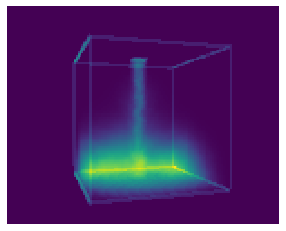

In [22]:
%%time

x = np.zeros((m,n,p))

def take_scalar(a,indices_i, indices_j, indices_k) :
    m,n,p = a.shape[:3]
    full_idices = p*(n*indices_i + indices_j) + indices_k
    reshaped = a.reshape(m*n*p)
    res = np.take(reshaped,full_idices, axis=0)
    return res.reshape(m,n,p)

def update_scalar(s,w,dt) :
    m,n,p = w.shape[:3]
    indices = np.indices((m,n,p)).swapaxes(0,1).swapaxes(1,2).swapaxes(2,3) - dt*w
    indices_floor = np.floor(indices).astype(np.int)
    frac = indices-indices_floor
    frac = [1-frac,frac]
    indices_ceil = indices_floor + 1
    indices_floor[:,:,:,0] = np.clip(indices_floor[:,:,:,0], 0, m-1)
    indices_ceil[:,:,:,0] = np.clip(indices_ceil[:,:,:,0], 0, m-1)
    indices_floor[:,:,:,1] = np.clip(indices_floor[:,:,:,1], 0, n-1)
    indices_ceil[:,:,:,1] = np.clip(indices_ceil[:,:,:,1], 0, n-1)
    indices_floor[:,:,:,2] = np.clip(indices_floor[:,:,:,2], 0, p-1)
    indices_ceil[:,:,:,2] = np.clip(indices_ceil[:,:,:,2], 0, p-1)
    indices = [indices_floor, indices_ceil] # shape : 2 m,n,p,3

    res = np.zeros((m,n,p))
    for i in range(2) :
        for j in range(2) :
            for k in range(2) :
                res += np.reshape(frac[i][:,:,:,0]*frac[j][:,:,:,1]*frac[k][:,:,:,2], (m,n,p)) * take_scalar(x, indices[i][:,:,:,0], indices[j][:,:,:,1], indices[k][:,:,:,2])
    res = res*1
    res[17:22,1,17:22] = 1
    return res

camera_pos = np.array([-m,n/2,p/2])

fig = plt.figure()
ims = []

renderer = Renderer(120,150, 170)

center = (np.array([m,n,p])-1)/2
t = 0
for i in range(500) :
    dt=1
    sim.time_step(dt)
    x = update_scalar(x,sim.w,dt)
    x_proj = np.amax(x,-1)
    if not i % 50 :
        print(i)
    if not i % 1 :
        t+=0.01
        camera_pos = center +100*np.array([-np.cos(t),0,-np.sin(t)])
        plt.axis('off')
        res = renderer(x, camera_pos)
        ims.append([plt.imshow(res, animated=True)])
        

In [24]:
ani1 = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani1.to_html5_video())